In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
almost_black = '#262626'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.edgecolor'] = almost_black
plt.rcParams['text.color'] = almost_black
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 12

In [4]:
company_msci = pd.read_csv("esg_ratings.csv", index_col=0)

In [5]:
company_msci.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6068 entries, 0 to 6067
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ISSUER_NAME                 6068 non-null   object 
 1   ISSUER_TICKER               4458 non-null   object 
 2   ISSUER_CNTRY_DOMICILE_NAME  6068 non-null   object 
 3   IVA_INDUSTRY                5233 non-null   object 
 4   GICS_SUB_IND                5276 non-null   object 
 5   IVA_COMPANY_RATING          2034 non-null   object 
 6   INDUSTRY_ADJUSTED_SCORE     2034 non-null   float64
 7   AGR_RATING                  4828 non-null   object 
 8   GOVERNANCE_SCORE            2087 non-null   float64
dtypes: float64(2), object(7)
memory usage: 474.1+ KB


In [6]:
# With count aggregation we can explore which countries we have very little data of
companies_by_country= company_msci.groupby("ISSUER_CNTRY_DOMICILE_NAME")\
        [['ISSUER_NAME']].size()\
        .sort_values(ascending=False).to_frame()\
        .reset_index()\
        .rename(columns={
            'ISSUER_CNTRY_DOMICILE_NAME': 'Country',
            0: 'Companies'})

In [7]:
companies_by_country.describe()

,Companies
count,35.000000
mean,173.371429
std,257.414873
min,3.000000
25%,21.500000
50%,79.000000
75%,222.000000
max,1359.000000


In [8]:
companies_by_country.head()

,Country,Companies
0,United Kingdom,1359
1,Sweden,624
2,France,522
3,Germany,474
4,Italy,302


In [9]:
companies_by_country.tail()

,Country,Companies
30,Ukraine,13
31,Bosnia and Herzegovina,8
32,Latvia,6
33,Slovakia,5
34,Montenegro,3


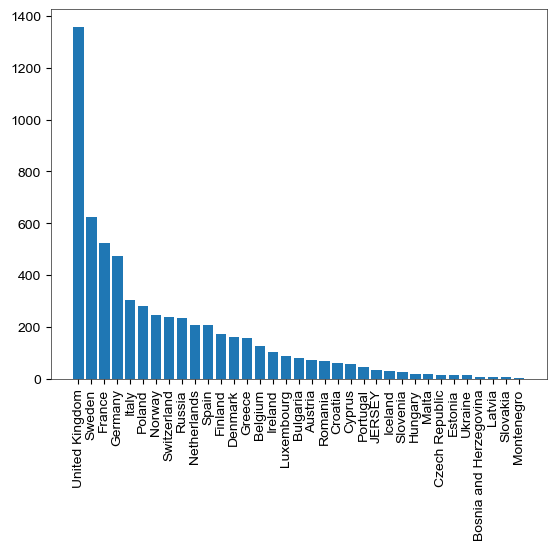

In [10]:
plt.bar(companies_by_country.Country, companies_by_country.Companies)
plt.xticks(rotation=90)

plt.show()

In [11]:
companies_by_country['size_quantile'] = pd.qcut(companies_by_country['Companies'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [12]:
from seaborn import boxplot

In [13]:
def getQuantileStats(df, value, quantile_column):
    quantile_stats = df.groupby(quantile_column, observed=True)[value].agg(['min', 'max', 'mean', 'std'])
    return quantile_stats

In [14]:
quantiles = set(companies_by_country['size_quantile'])
quantiles

{'Q1', 'Q2', 'Q3', 'Q4'}

c:\Users\gusta\miniconda3\envs\gus\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


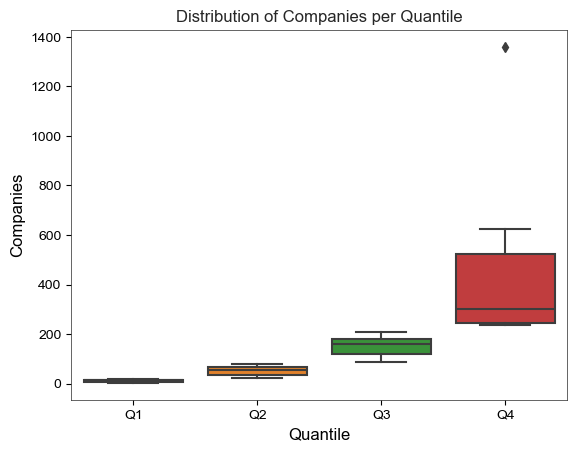

In [15]:
boxplot(data=companies_by_country, x='size_quantile', y='Companies')
plt.xlabel("Quantile")
plt.title("Distribution of Companies per Quantile")
plt.show()

In [16]:
print(getQuantileStats(companies_by_country, 'Companies', 'size_quantile'))

               min   max        mean         std
size_quantile                                   
Q1               3    19   11.222222    5.868939
Q2              24    79   51.444444   19.881594
Q3              89   208  152.750000   43.738672
Q4             236  1359  475.777778  360.419470


In [17]:
companies_by_country.describe()

,Companies
count,35.000000
mean,173.371429
std,257.414873
min,3.000000
25%,21.500000
50%,79.000000
75%,222.000000
max,1359.000000


Fairly divided quantiles in terms of number of companies on the Morgan Stanely Platform, where Q5 has the biggest dispersion

## Next, take a look at each of the statistics given

The IVA rating is the intangible value assessment, it provides a rank based on industry research and analysis of corporate management of environmental and social risk factors. It is used to measure investment risk and opportunity from an ESG lense of each company **Source: MSCI_ESG_IVA.pdf**

In [65]:
esg_ratings = company_msci.drop(columns=["ISSUER_TICKER", "INDUSTRY_ADJUSTED_SCORE"])\
    .dropna(subset=['IVA_COMPANY_RATING', 'AGR_RATING', 'GOVERNANCE_SCORE'], how='all')\
    .rename(columns=
            {
                "ISSUER_NAME": 'Company',
                "ISSUER_CNTRY_DOMICILE_NAME": 'Country',
                "IVA_INDUSTRY": "Industry",
                "GICS_SUB_IND": "Subindustry",
                "IVA_COMPANY_RATING": 'IVA_Rating',
                'AGR_RATING': 'AGR_Rating',
                'GOVERNANCE_SCORE': 'Governance_Score'
            }).reset_index(drop=True)
esg_ratings

,Company,Country,Industry,Subindustry,IVA_Rating,AGR_Rating,Governance_Score
0,1&1 AG,Germany,Telecommunication Services,Wireless Telecommunication Services,BBB,Average Variance,7.1
1,11 88 0 Solutions AG,Germany,NaN,Diversified Support Services,NaN,Average Variance,NaN
2,11 Bit Studios SA,Poland,Software & Services,Interactive Home Entertainment,NaN,Average Variance,NaN
3,1Spatial PLC,United Kingdom,Software & Services,IT Consulting & Other Services,NaN,Above-Average Variance,NaN
4,24Storage AB,Sweden,Commercial Services & Supplies,Diversified Support Services,NaN,Above-Average Variance,NaN
...,...,...,...,...,...,...,...
5278,Wienerberger AG,Austria,Construction Materials,Construction Materials,AAA,Above-Average Variance,9.1
5279,Wolford Aktiengesellschaft,Austria,"Textiles, Apparel & Luxury Goods","Apparel, Accessories & Luxury Goods",NaN,Above-Average Variance,NaN
5280,Zumtobel Group AG,Austria,Electrical Equipment,Electrical Components & Equipment,NaN,Average Variance,NaN
5281,ams-OSRAM AG,Austria,Semiconductors & Semiconductor Equipment,Semiconductors,BBB,Above-Average Variance,7.5


In [66]:
set(esg_ratings['IVA_Rating'])

{'A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'CCC', nan}

Now we will give the letter scores a value, such that:<br>
AAA = 10 <br>
AA = 9 <br>
A = 8 <br>
BBB = 7 <br>
BB = 6 <br>
B = 5 <br>
CCC = 4 <br>

In [67]:
iva_rating_dictionary = {
    'AAA': 10,
    'AA': 9,
    'A': 8,
    'BBB': 7,
    'BB': 6,
    'B': 5,
    'CCC': 4,
    'CC': 3,
    'C': 2,
    'DDD': 1
}

In [68]:
esg_ratings['iva_adjusted'] = esg_ratings['IVA_Rating'].map(iva_rating_dictionary)

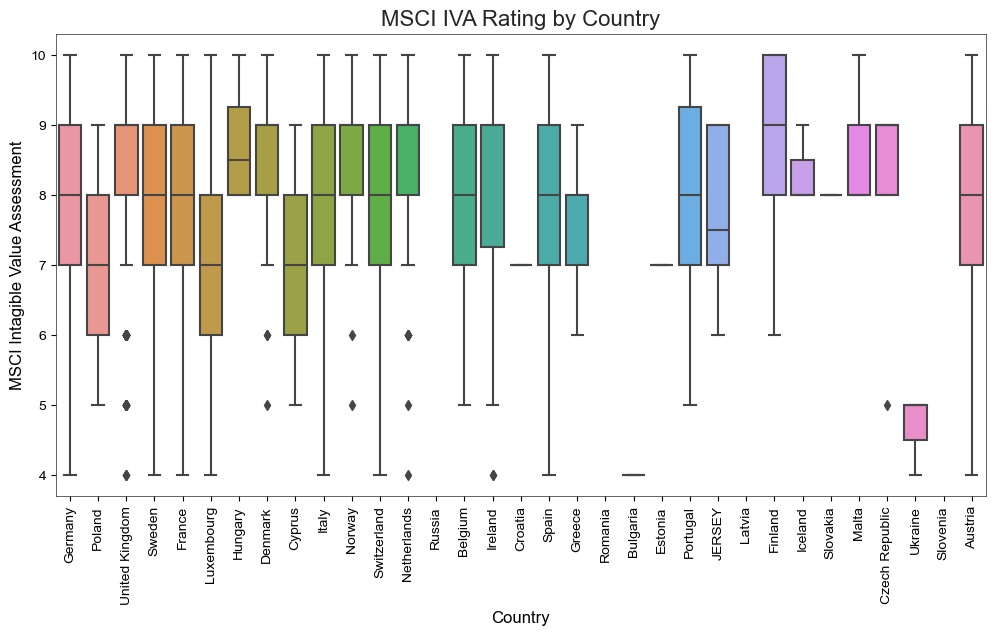

In [69]:
fig = plt.figure(figsize=(12,6))
boxplot(data=esg_ratings, x='Country', y='iva_adjusted')

plt.xticks(rotation=90)
plt.ylabel("MSCI Intagible Value Assessment")
plt.title("MSCI IVA Rating by Country", fontsize="16")

plt.show()

Looks like most countries average on 8, with the UK and Finaland being the only 2 with higher averages and the smaller and more developing nations having lower averages, as expected

In [70]:
set(esg_ratings['AGR_Rating'])

{'Above-Average Variance',
 'Average Variance',
 'High Variance',
 'Low Variance',
 nan}

In [114]:
agr_rating_dictionary = {
    'Low Variance': 10,
    'Below-Average Variance': 7,
    'Average Variance': 5,
    'Above-Average Variance': 3,
    'High Variance': 0,
}

In [115]:
esg_ratings['agr_var_adjusted'] = esg_ratings['AGR_Rating'].map(agr_rating_dictionary)

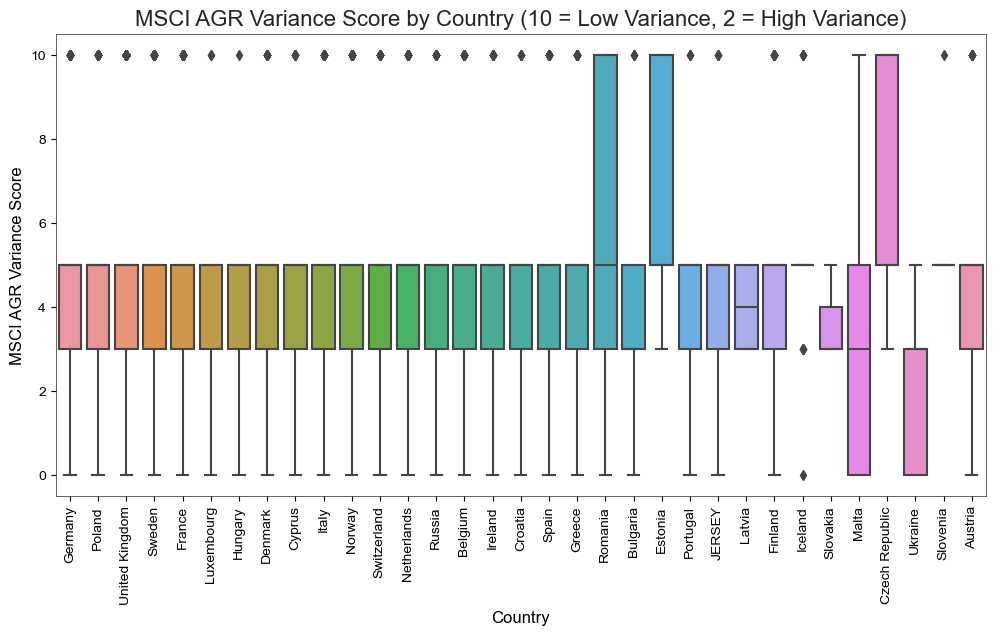

In [116]:
fig = plt.figure(figsize=(12,6))
boxplot(data=esg_ratings, x='Country', y='agr_var_adjusted')

plt.xticks(rotation=90)
plt.ylabel("MSCI AGR Variance Score")
plt.title("MSCI AGR Variance Score by Country (10 = Low Variance, 2 = High Variance)", fontsize="16")

plt.show()

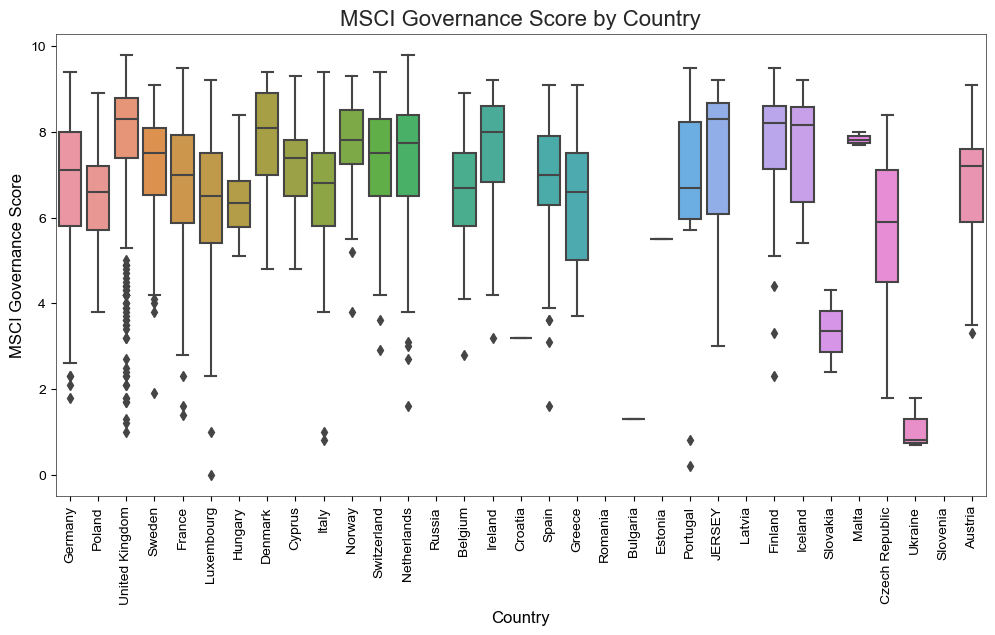

In [85]:
fig = plt.figure(figsize=(12,6))
boxplot(data=esg_ratings, x='Country', y='Governance_Score')

plt.xticks(rotation=90)
plt.ylabel("MSCI Governance Score")
plt.title("MSCI Governance Score by Country", fontsize="16")

plt.show()

# Rating by Industry

The goal here is to recognize variance by industry

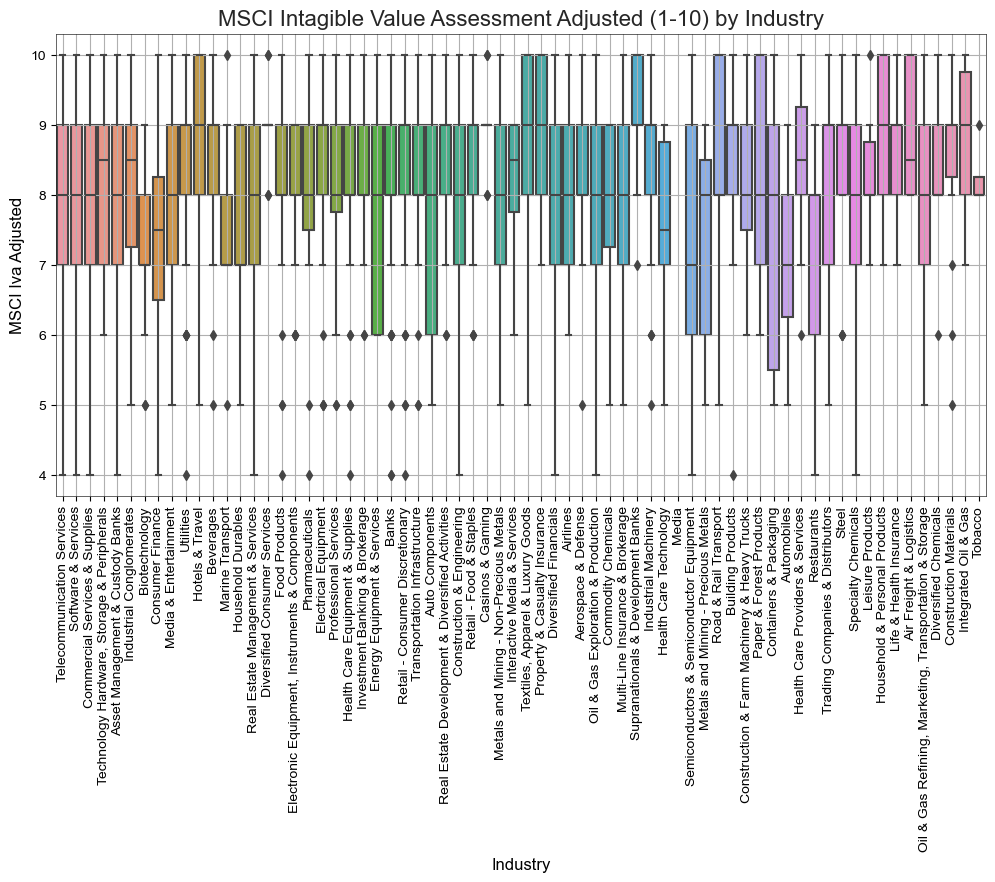

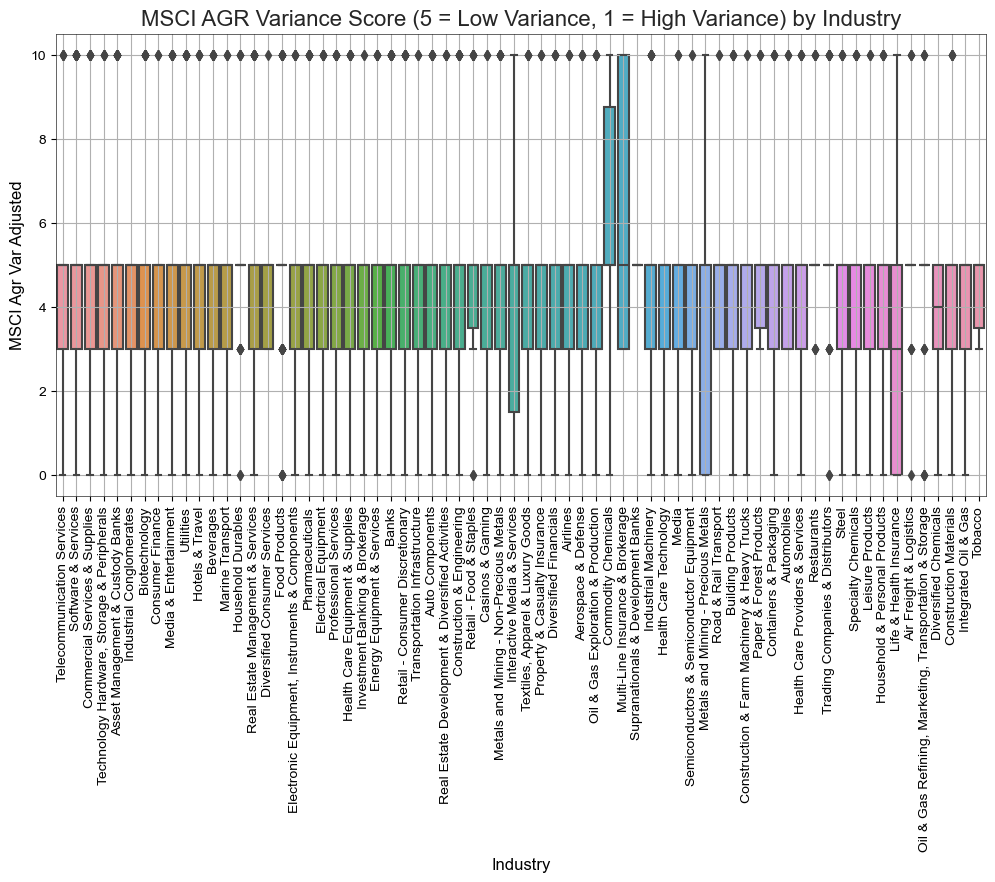

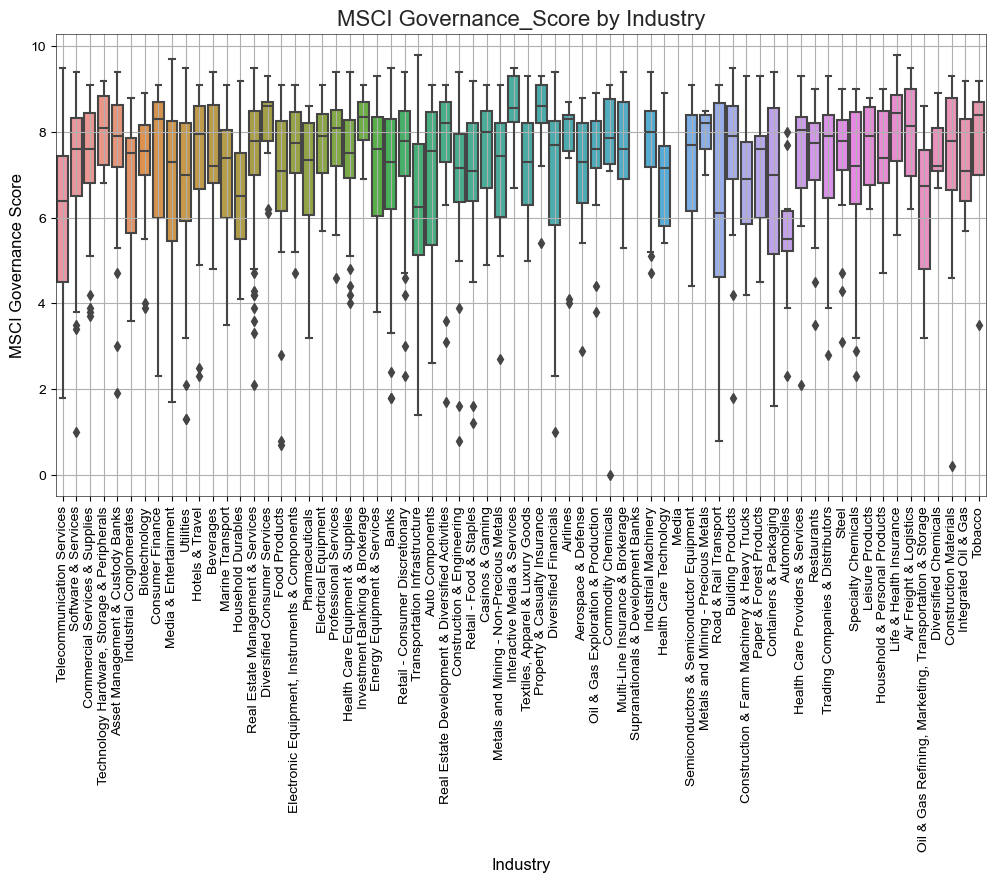

In [117]:
for var, title in zip(
    ['iva_adjusted', 'agr_var_adjusted', 'Governance_Score'],
    ['Intagible Value Assessment Adjusted (1-10)', 'AGR Variance Score (5 = Low Variance, 1 = High Variance)', 'Governance_Score']):

    fig = plt.figure(figsize=(12,6))
    boxplot(data=esg_ratings, x='Industry', y=var)

    plt.xticks(rotation=90)
    plt.ylabel(f"MSCI {var.replace("_", " ").title()}")
    plt.title(f"MSCI {title} by Industry", fontsize="16")
    plt.grid(True)

    plt.show()

### IVA
While this graph my be overwhelming, we can conclude that most industries have similar variance, where the mean of each does not fall below 7, and road and transportation tends to have the highest. We will not look at this further but keep this in mind when analyzing the individual countries

### AGR
In terms of volatility of industries, it appears most industries to be stable and offer a mean with the average variance, with the notable exceptions of commodity chemicals and multiline insurance and brokerage being less volatile, and life and health insurance being the most volatile

### Governace
While there is a lot of variance in the higher ranks, most industries, outside of automobiles, faired higher than a 7.

For the sake of consistency, we will not be looking out countries that have **less than 10 companies**. This is to prevent a few companies from skewing the data

In [124]:
agg_iva = esg_ratings.groupby('Country', as_index=False)['iva_adjusted'].agg(['count', 'mean', 'median', 'std']).query('count >= 10')
agg_iva.rename(columns={'mean':'MSCI_IVA_Adjusted_Mean'}, inplace=True)
agg_iva

,Country,count,MSCI_IVA_Adjusted_Mean,median,std
0,Austria,36,7.861111,8.0,1.437315
1,Belgium,52,7.961538,8.0,1.251846
6,Denmark,54,8.444444,9.0,1.207940
8,Finland,48,8.979167,9.0,1.061704
9,France,175,8.165714,8.0,1.282496
10,Germany,207,7.971014,8.0,1.372097
11,Greece,15,7.733333,8.0,0.798809
14,Ireland,50,8.140000,9.0,1.511993
15,Italy,112,7.544643,8.0,1.381267
16,JERSEY,10,7.700000,7.5,1.251666


In [125]:
agg_agr = esg_ratings.groupby('Country', as_index=False)['agr_var_adjusted'].agg(['count', 'mean', 'median', 'std']).query('count >= 10')
agg_agr.rename(columns={'mean':'MSCI_AGR_Var_Mean'}, inplace=True)
agg_agr

,Country,count,MSCI_AGR_Var_Mean,median,std
0,Austria,54,5.129630,5.0,2.848676
1,Belgium,109,4.899083,5.0,2.663001
2,Bulgaria,63,3.619048,3.0,2.337828
3,Croatia,44,4.863636,5.0,2.163018
4,Cyprus,42,4.666667,5.0,2.893784
6,Denmark,113,4.867257,5.0,2.523123
7,Estonia,10,6.800000,5.0,2.820559
8,Finland,142,4.690141,5.0,2.475936
9,France,429,4.855478,5.0,2.582761
10,Germany,396,4.661616,5.0,2.388080


In [126]:
agg_gov = esg_ratings.groupby('Country', as_index=False)['Governance_Score'].agg(['count', 'mean', 'median', 'std']).query('count >= 10')
agg_gov.rename(columns={'mean':'MSCI_Goverance_Score_Mean'}, inplace=True)
agg_gov

,Country,count,MSCI_Goverance_Score_Mean,median,std
0,Austria,37,6.848649,7.20,1.351465
1,Belgium,54,6.620370,6.70,1.337892
6,Denmark,53,7.920755,8.10,1.187816
8,Finland,50,7.712000,8.20,1.525516
9,France,172,6.725000,7.00,1.621245
10,Germany,209,6.719617,7.10,1.592636
11,Greece,21,6.304762,6.60,1.456872
14,Ireland,52,7.559615,8.00,1.476517
15,Italy,115,6.626087,6.80,1.380890
16,JERSEY,10,7.270000,8.30,2.109265


# Putting it all together

In [133]:
esg_data_country = pd.merge(
    pd.merge(
        # First merge joins IVA with AGR
        agg_iva.iloc[:, [0, 2]], 
        agg_agr.iloc[:, [0, 2]], 
        on = 'Country', how = "outer"
        ), 
    # Second merge, appends the governance score as well
    agg_gov.iloc[:, [0, 2]],
    on = 'Country',
    how = 'outer'
)

# ensure all countries are title case
esg_data_country['Country'] = esg_data_country['Country'].str.title()

esg_data_country.sort_values('Country', inplace=True)
esg_data_country.reset_index(drop=True, inplace=True)
esg_data_country

,Country,MSCI_IVA_Adjusted_Mean,MSCI_AGR_Var_Mean,MSCI_Goverance_Score_Mean
0,Austria,7.861111,5.129630,6.848649
1,Belgium,7.961538,4.899083,6.620370
2,Bulgaria,NaN,3.619048,NaN
3,Croatia,NaN,4.863636,NaN
4,Cyprus,NaN,4.666667,NaN
5,Denmark,8.444444,4.867257,7.920755
6,Estonia,NaN,6.800000,NaN
7,Finland,8.979167,4.690141,7.712000
8,France,8.165714,4.855478,6.725000
9,Germany,7.971014,4.661616,6.719617


In [122]:
esg_data_country.to_csv("MSCI Ratings Aggregated.csv", index=False)